In [2]:
import tensorflow as tf
from tensorflow import keras 
from keras import utils
import numpy as np
from sklearn.metrics import  auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

In [2]:
path = "D:\\Projects\\Bone Fracture Classifier\\Test\\"

In [3]:
test_data = utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40,
)
label=test_data.class_names

Found 140 files belonging to 10 classes.


In [4]:
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img
test_dataset = test_data.map(lambda x, y: (preprocess(x), y))

In [5]:
x_test = []
y_test = []
for images, labels in test_dataset:
        x_test.append(images.numpy())
        y_test.append(labels.numpy())
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [6]:
Num_Labels = len(label)
y_test = utils.to_categorical(y_test, Num_Labels)

In [7]:
class_of_interest = 0

In [8]:
model = tf.keras.models.load_model("D:\\Projects\\Bone Fracture Classifier\\models\\Sequential.keras")

In [9]:
y_score = model.predict(x_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step


In [10]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.8393 - loss: 0.7573
Test Loss: 0.6236886978149414
Test Accuracy: 0.8642857074737549


In [11]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)
y_test_binarized = label_binarizer.transform(y_test)
y_pred_probs = model.predict(x_test) 
class_labels = ['Avulsion Fracture', 'Comminuted Facture', 'Fracture Dislocation', 'Greenstick Fracture', 'Hairline Fracture', 'Impacted Fracture', 'Longitudinal Fracture', 'Oblique Fracture', 'Pathological Fracture', 'Spiral Fracture']
auroc_scores = []
for i in range(y_test_binarized.shape[1]):
    auroc_score = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    auroc_scores.append(auroc_score)
df = pd.DataFrame({
    'Class': class_labels,
    'AUROC Score': auroc_scores
})
print(df)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
                   Class  AUROC Score
0      Avulsion Fracture     0.964853
1     Comminuted Facture     0.973356
2   Fracture Dislocation     1.000000
3    Greenstick Fracture     0.992944
4      Hairline Fracture     0.998462
5      Impacted Fracture     1.000000
6  Longitudinal Fracture     0.967448
7       Oblique Fracture     0.949093
8  Pathological Fracture     0.985883
9        Spiral Fracture     1.000000


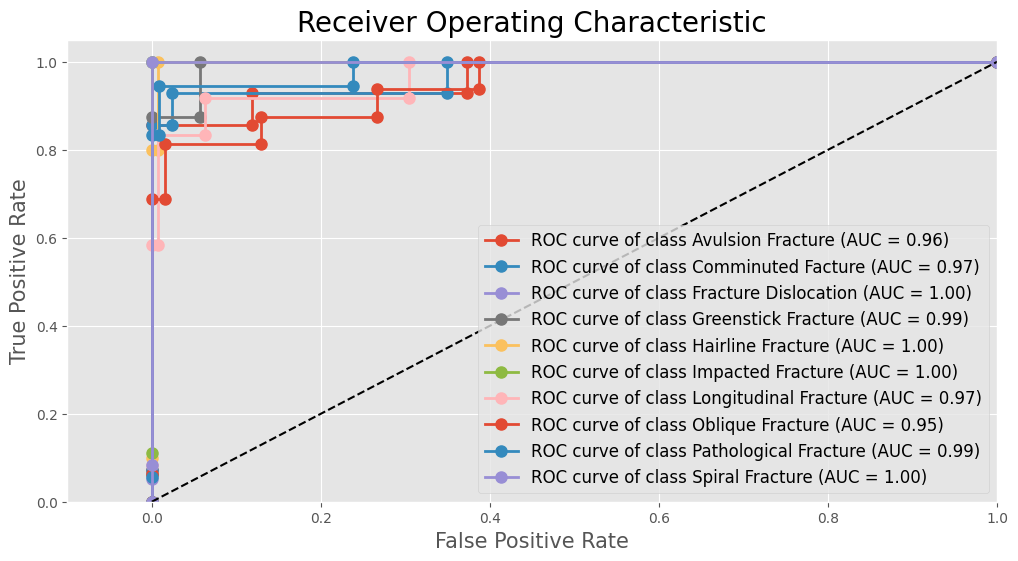

In [12]:

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'o-', linewidth=2, markersize=8, label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic', fontsize=20)
plt.grid(True)
plt.legend(loc="lower right", fontsize=12)
plt.show()

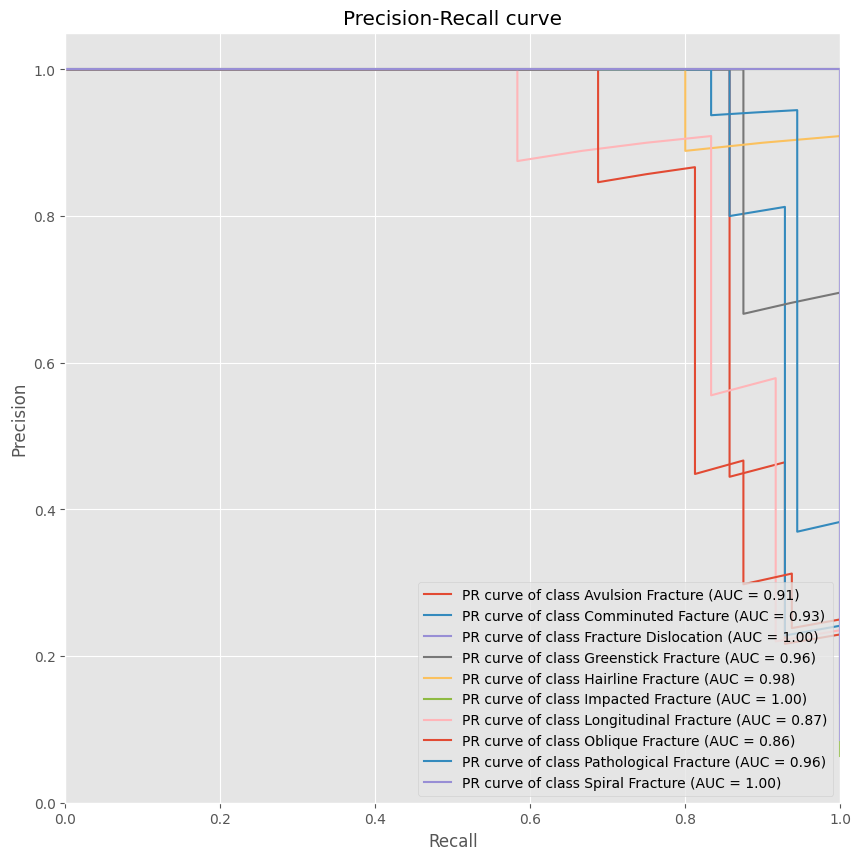

In [13]:

plt.figure(figsize=(10, 10))
for i in range(y_test_binarized.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'PR curve of class {class_labels[i]} (AUC = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

In [14]:

fpr, tpr, thresholds = roc_curve(y_test_binarized[:, 0], y_pred_probs[:, 0])
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
for threshold in thresholds:
    y_pred = np.where(y_pred_probs[:, 0] >= threshold, 1, 0)
    accuracy_scores.append(accuracy_score(y_test_binarized[:, 0], y_pred))
    precision_scores.append(precision_score(y_test_binarized[:, 0], y_pred))
    recall_scores.append(recall_score(y_test_binarized[:, 0], y_pred))
    f1_scores.append(f1_score(y_test_binarized[:, 0], y_pred))
df = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})
print(df)

      Threshold       TPR       FPR  Accuracy  Precision    Recall  F1 Score
0           inf  0.000000  0.000000  0.900000   0.000000  0.000000  0.000000
1  9.992515e-01  0.071429  0.000000  0.907143   1.000000  0.071429  0.133333
2  5.660495e-01  0.857143  0.000000  0.985714   1.000000  0.857143  0.923077
3  1.379301e-02  0.857143  0.119048  0.878571   0.444444  0.857143  0.585366
4  1.363608e-02  0.928571  0.119048  0.885714   0.464286  0.928571  0.619048
5  7.569787e-04  0.928571  0.373016  0.657143   0.216667  0.928571  0.351351
6  6.416815e-04  1.000000  0.373016  0.664286   0.229508  1.000000  0.373333
7  2.211732e-09  1.000000  1.000000  0.100000   0.100000  1.000000  0.181818


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
